In [1]:
%load_ext autoreload
%autoreload 2
import copy
import gc
import sys
import pickle

sys.path.append('..')

import numpy as np
import pandas as pd
import scipy.stats as sps

import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm

from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import Ridge
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler


from src.utils.cross_validation import TimeSeriesGroupSplit
from src.utils.downcasting import downcast_dtypes

sns.set(font_scale=1.2)
%matplotlib inline

In [2]:
max_text_features = 20
random_state = 42

BEST_CONSTANT = 0.2839
MEAN_CONSTANT = 0.3343

# Ridge

In this notebook we will produce predictions by Ridge.

## Preparing datasets

In this section we will load all datasets and prepare them for training.

In [3]:
sales_train = pd.read_csv('../data/processed/sales_train.csv')
train = pd.read_feather('../data/processed/train.ftr')
test = pd.read_feather('../data/processed/test.ftr')

items = pd.read_csv('../data/processed/items.csv')
tfidf_truncated_svd = pd.read_feather('../data/processed/text/tfidf_truncated-svd.ftr')

In [4]:
train.drop(columns=['index'], inplace=True)
test.drop(columns=['index', 'level_0'], inplace=True)

### Adding text features

In [5]:
tfidf_truncated_svd = tfidf_truncated_svd[tfidf_truncated_svd.columns[:max_text_features]]

In [6]:
tfidf_truncated_svd['item_id'] = items.item_id

In [7]:
train = pd.merge(
    train,
    tfidf_truncated_svd,
    how='left', on='item_id'
)

test = pd.merge(
    test,
    tfidf_truncated_svd,
    how='left', on='item_id'
)

gc.collect();

### Clipping target

According to evaluation, target will be clipped between 0 and 20. Let's do it in our dataset.

In [8]:
train.target = np.clip(train.target, 0, 20)

### Process categorical data

Find categorical columns.

In [9]:
categorical_types = ['object', 'bool']

In [10]:
train.dtypes[np.isin(train.dtypes.values, categorical_types)]

item_name                  object
item_in_test                 bool
item_full_category_name    object
item_category_name         object
item_subcategory_name      object
shop_name                  object
city                       object
shop_in_test                 bool
dtype: object

Don't touch boolean objects, they are already label encoded.

Let's remove columns `item_name`, `shop_name`, because we already have them label encoded as `item_id`, `shop_id`.

In [11]:
train.drop(columns=['item_name', 'shop_name'], inplace=True)
test.drop(columns=['item_name', 'shop_name'], inplace=True)

Let's define list with all categorical values.

In [12]:
categorical_features = [
    'month', 'item_id', 'item_full_category_name', 'item_category_name', 
    'item_subcategory_name', 'shop_id', 'city'
]

#### Mean encoding

In [13]:
for column in tqdm(categorical_features):
    # encode train
    cumsum = train.groupby(column).target.cumsum() - train.target
    cumcount = train.groupby(column).cumcount()
    encoded_feature = cumsum / cumcount
    encoded_feature.fillna(MEAN_CONSTANT, inplace=True)
    
    train[f'{column}_mean_encoded_mean'] = encoded_feature
    
    # encode test
    mean_train = train.groupby(column).target.mean()
    test[f'{column}_mean_encoded_mean'] = test[column].map(mean_train).fillna(MEAN_CONSTANT)

Drop all non encoded columns.

In [14]:
train.drop(columns=categorical_features, inplace=True)
test.drop(columns=categorical_features, inplace=True)

### Processing NaNs

Fill NaNs.

In [15]:
train.columns[train.isna().sum() > 0]

Index(['num_residents'], dtype='object')

As we expected there are some problems only with `num_residents`. We can fill it with zero, because it will be border value for this feature, trees can handle it properly.

In [16]:
train.fillna(0, inplace=True)
test.fillna(0, inplace=True)

### Removing target

Remove target from train.

In [17]:
y = train.target
train.drop(columns=['target'], inplace=True)

### Creation of validation split

Let's also delete from train rows that appears only on validation, it will make our train/validation split more consistant with train/test split.

In [18]:
X_valid = train[train.date_block_num == 33]
X_train = train[train.date_block_num < 33]
y_valid = y[train.date_block_num == 33]
y_train = y[train.date_block_num < 33]
X_test = test
    
del train, test
gc.collect()

39

## Hyperparameters tuning

In this section we will find optimum parameters for a model. Firstly, fix the result before any optimization. Parameters:
* `alpha`

In [19]:
ts = TimeSeriesGroupSplit(n_splits=5, max_train_size=int(1.5*10**6))

ridge_params = {
    'random_state': random_state
}

In [20]:
# pipe_ridge = Pipeline([('standartization', StandardScaler()), 
#                        ('regression', Ridge(**ridge_params))])

# default_score = cross_val_score(
#     pipe_ridge, 
#     X_train, y_train, groups=X_train.date_block_num,
#     n_jobs=1, 
#     scoring='neg_root_mean_squared_error', 
#     verbose=0,
#     cv=ts
# ).mean()
# print(f'Default score: {-default_score:.5f}')

Score: $1.06697$.

Now we will try to find better parameters.

In [21]:
pipe_ridge = Pipeline([('standartization', StandardScaler()), 
                       ('regression', Ridge(**ridge_params))])

param_grid = {
    'regression__alpha': np.logspace(4, 6, 5),
}

gs = GridSearchCV(
    pipe_ridge, 
    param_grid,          
    n_jobs=1, 
    scoring='neg_root_mean_squared_error', 
    verbose=10,
    refit=False,
    cv=ts
)

gs.fit(X_train, y_train, groups=X_train.date_block_num)

gs.best_score_

In [22]:
ridge_params['alpha'] = 316228

In [23]:
# pipe_ridge = Pipeline([('standartization', StandardScaler()), 
#                        ('regression', Ridge(**ridge_params))])

# current_score = cross_val_score(
#     pipe_ridge, 
#     X_train, y_train, groups=X_train.date_block_num,
#     n_jobs=1, 
#     scoring='neg_root_mean_squared_error', 
#     verbose=0,
#     cv=ts
# ).mean()
# print(f'Current score: {-current_score:.5f}')

Score: $1.00449$.

In [24]:
ridge_params

{'random_state': 42, 'alpha': 316228}

## Validation

In this section we will validate best parameters using haldout. We will use not all train, because of limitation of RAM.

In [ ]:
(X_train.date_block_num >= 25).sum()

In [ ]:
start_date_block_num = 25
indices_train = (X_train.date_block_num >= start_date_block_num)
X_train = X_train[indices_train]
y_train = y_train[indices_train]
gc.collect();

In [ ]:
model = Pipeline([('standartization', StandardScaler()), 
                  ('regression', Ridge(**ridge_params))])
model.fit(X_train, y_train)

In [ ]:
y_predicted = np.clip(model.predict(X_valid), 0, 20)
validation_score = mean_squared_error(y_valid, y_predicted)
print(f'Validation score: {validation_score:.5f}')

Score: $1.08194$

Let's look at predicted values charasteristics.

In [ ]:
pd.Series(y_predicted).describe()

Let's look at feature importances.

In [ ]:
ridge_coefs = model.named_steps['regression'].coef_
top_size = 10

top_positive_indices = np.argsort(ridge_coefs)[-top_size:]
top_negative_indices = np.argsort(ridge_coefs)[:top_size]
top_positive_names = X_train.columns[top_positive_indices]
top_negative_names = X_train.columns[top_negative_indices]

In [25]:
# plt.figure(figsize=(16, 9))
# sns.barplot(y=top_positive_names[::-1], 
#             x=ridge_coefs[top_positive_indices][::-1])
# plt.xlabel('Коэффициент перед признаком')
# plt.title(f'Топ-{top_size} наиболее значимых признаков с '
#           'положительным коэффициентом для Ridge-регрессии')
# plt.savefig('../reports/figures/ridge/positive_importances.png', 
#             facecolor='white', bbox_inches='tight', pad_inches=0)
# plt.show()

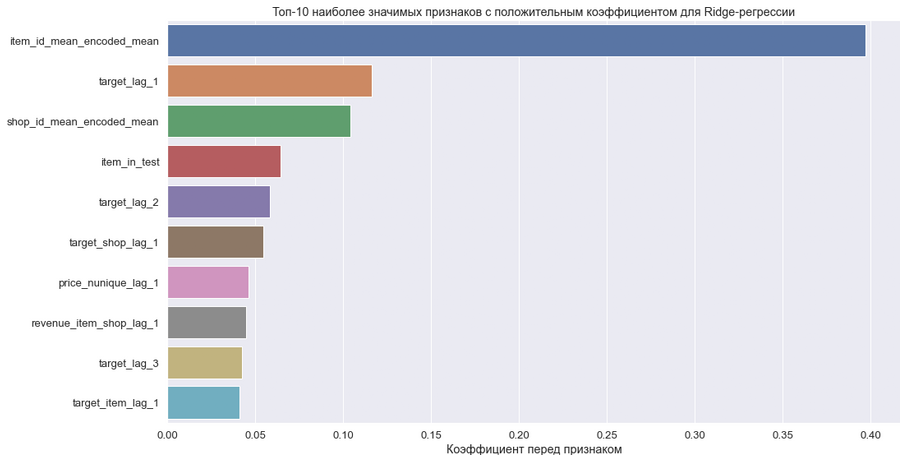

In [26]:
plt.figure(figsize=(16, 9))
image = plt.imread('../reports/figures/ridge/positive_importances.png')
plt.imshow(image, interpolation='spline36')
plt.axis('off')
plt.show()

In [27]:
# plt.figure(figsize=(16, 9))
# sns.barplot(y=top_negative_names[::-1], 
#             x=ridge_coefs[top_negative_indices][::-1])
# plt.xlabel('Коэффициент перед признаком')
# plt.title(f'Топ-{top_size} наиболее значимых признаков с '
#           'отрицательным коэффициентом для Ridge-регрессии')
# plt.savefig('../reports/figures/ridge/negative_importances.png', 
#             facecolor='white', bbox_inches='tight', pad_inches=0)
# plt.show()

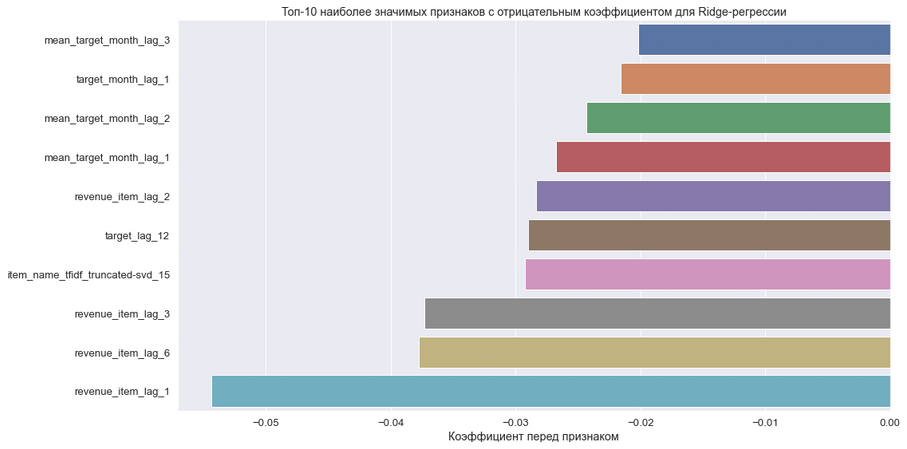

In [28]:
plt.figure(figsize=(16, 9))
image = plt.imread('../reports/figures/ridge/negative_importances.png')
plt.imshow(image, interpolation='spline36')
plt.axis('off')
plt.show()

## Submit

In this section we will train result model and submit prediction. Don't forget to clip values according to [evaluation tab](https://www.kaggle.com/c/competitive-data-science-predict-future-sales/overview/evaluation) (but ay be for tree-based methods it is not necessary).

In [29]:
X_train = pd.concat((X_train, X_valid))
y_train = pd.concat((y_train, y_valid))
gc.collect();

In [30]:
X_train.shape

(5667543, 106)

In [ ]:
start_date_block_num = 25
indices_train = (X_train.date_block_num >= start_date_block_num)
X_train = X_train[indices_train]
y_train = y_train[indices_train]
gc.collect();

In [ ]:
model = Pipeline([('standartization', StandardScaler()), 
                  ('regression', Ridge(**ridge_params))])
bags = 5

bagged_predictions = np.zeros(X_test.shape[0])
for n in tqdm(range(bags)):
    model.set_params(**{'regression__random_state': random_state+n})
    model.fit(X_train, y_train)
    bagged_predictions += np.clip(model.predict(X_test), 0, 20)
    gc.collect()
    
bagged_predictions /= bags

Create submission.

In [ ]:
pd.Series(bagged_predictions).describe()

In [ ]:
submission = pd.read_csv('../data/raw/sample_submission.csv')
submission['item_cnt_month'] = bagged_predictions
submission.to_csv('../models/ridge/submission.csv', index=False)

!kaggle competitions submit competitive-data-science-predict-future-sales -f ../models/ridge/submission.csv -m "Ridge"

Result is $1.08655$. It is pretty far from top positions.

## OOF predictions

In this section we will create out-of-fold predictions for stacking. We will use cheme f), that was given in the course:
> In time-series task we usually have a fixed period of time we are asked to predict. Like day, week, month or arbitrary period with duration of T.
> 1. Split the train data into chunks of duration T. Select first M chunks.
> 2. Fit N diverse models on those M chunks and predict for the chunk M+1. Then fit those models on first M+1 chunks and predict for chunk M+2 and so on, until you hit the end. After that use all train data to fit models and get predictions for test. Now we will have meta-features for the chunks starting from number M+1 as well as meta-features for the test.
> 3. Now we can use meta-features from first K chunks [M+1,M+2,..,M+K] to fit level 2 models and validate them on chunk M+K+1. Essentially we are back to step 1. with the lesser amount of chunks and meta-features instead of features.

In [31]:
X_all = pd.concat((X_train, X_test))
test_size = X_test.shape[0]
del X_train, X_test
gc.collect();

In [32]:
num_blocks = X_all.date_block_num.nunique()
ts = TimeSeriesGroupSplit(n_splits=num_blocks-1, max_train_size=int(1.5*10**6))

We will use chunks, devided by `date_block_num`. In our case $M = 3$, but we won't use all previous chunks to train and limit it according to `max_train_size`.

In [33]:
model = Pipeline([('standartization', StandardScaler()), 
                  ('regression', Ridge(**ridge_params))])

predictions = np.zeros(X_all.shape[0])
filled_predictions = np.zeros(X_all.shape[0]).astype(bool)

for i, (train_idx, test_idx) in tqdm(
    enumerate(ts.split(X_all, groups=X_all.date_block_num)), total=22
):
    # skip too small training size
    if i < 2:
        continue
    model.fit(X_all.iloc[train_idx], y_train.iloc[train_idx])
    current_predictions = model.predict(X_all.iloc[test_idx])
    predictions[test_idx] = current_predictions
    filled_predictions[test_idx] = True
    
predictions = predictions[filled_predictions]
y_train = y_train.iloc[filled_predictions[:-test_size]]

Save columns of predictions and clipped predictions.

In [36]:
OOF_all = pd.DataFrame({'ridge': predictions, 
                        'ridge_clipped': np.clip(predictions, 0, 20)})
OOF_train = OOF_all.iloc[:-test_size].reset_index(drop=True)
OOF_train['target'] = y_train.values
OOF_test = OOF_all.iloc[-test_size:].reset_index(drop=True)

In [38]:
OOF_train.to_csv('../models/oof/ridge/train.csv', index=False)
OOF_test.to_csv('../models/oof/ridge/test.csv', index=False)